In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy

# Set a random seed for easy reproduction
random.seed(42)
np.random.seed(42)

# ---------------------
# Sample data generation
# ---------------------
def generate_sample_data(num_customers=10):
    coords = np.random.rand(num_customers, 2) * 100
    customers = [{'x': coords[i, 0], 'y': coords[i, 1]} for i in range(num_customers)]
    distance_matrix = np.zeros((num_customers, num_customers))

    for i in range(num_customers):
        for j in range(num_customers):
            if i != j:
                dx = customers[i]['x'] - customers[j]['x']
                dy = customers[i]['y'] - customers[j]['y']
                distance_matrix[i, j] = np.hypot(dx, dy)
            else:
                distance_matrix[i, j] = 0

    return {
        'customers': customers,
        'distance_matrix': distance_matrix,
        'drone_params': {
            'battery_life': 50,  # Range
            'time_weight': 1.0,
            'energy_weight': 1.0
        }
    }

sample_data = generate_sample_data(10)
sample_data['num_customers'] = 10
sample_data['num_drones'] = 2
sample_data['num_generations'] = 20
sample_data['pop_size'] = 10
sample_data['crossover_rate'] = 0.8
sample_data['mutation_rate'] = 0.2
sample_data['elitism'] = 1

sample_data.keys()


dict_keys(['customers', 'distance_matrix', 'drone_params', 'num_customers', 'num_drones', 'num_generations', 'pop_size', 'crossover_rate', 'mutation_rate', 'elitism'])

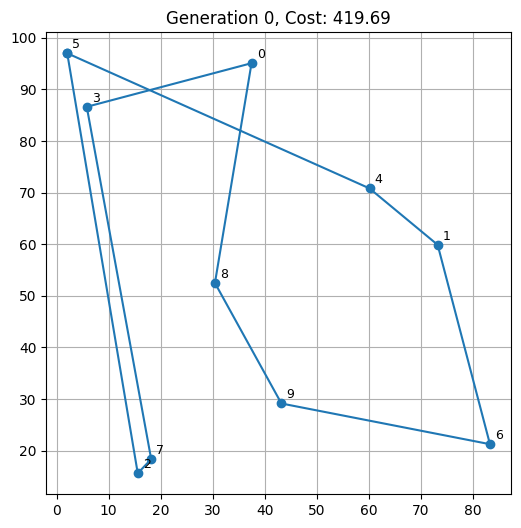

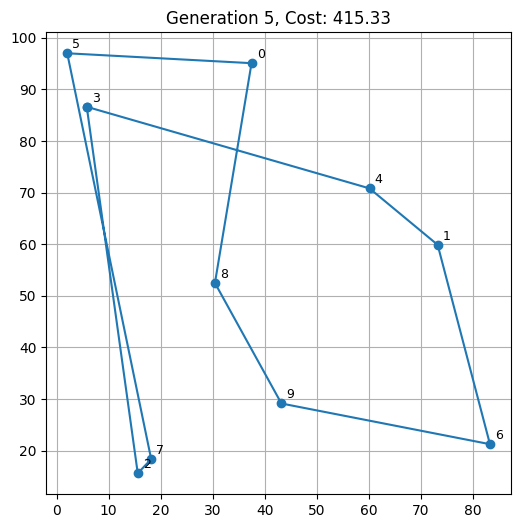

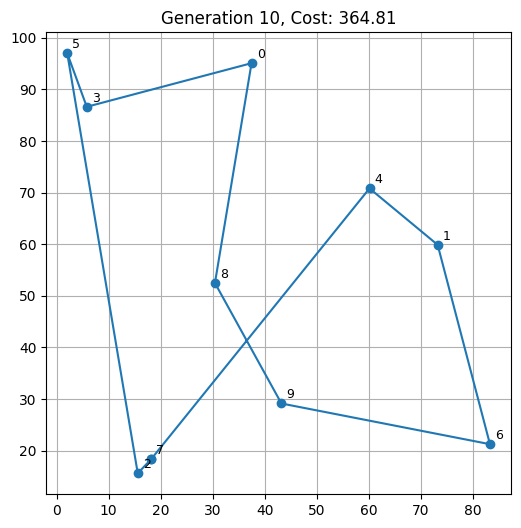

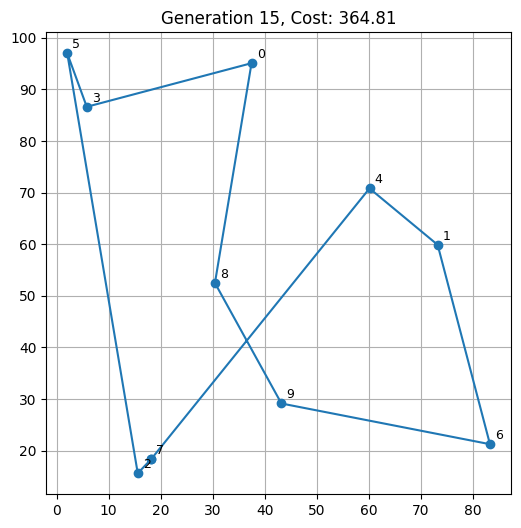

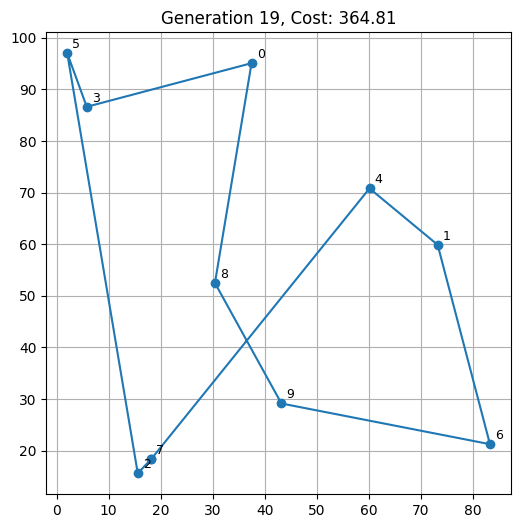

([7, 2, 5, 3, 0, 8, 9, 6, 1, 4], np.float64(364.8066743653475))

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Random seed
np.random.seed(42)

# Example parameters
num_customers = 10
num_drones = 2
customers = np.random.rand(num_customers, 2) * 100  # 顾客坐标 (x, y)
distance_matrix = np.linalg.norm(customers[:, np.newaxis, :] - customers[np.newaxis, :, :], axis=2)

# Drone parameters
drone_params = {
    'battery_capacity': 100,
    'time_weight': 0.5,
    'energy_weight': 0.5
}

# Genetic algorithm parameters
num_generations = 20
pop_size = 10
crossover_rate = 0.8
mutation_rate = 0.2
elitism = 1

# Evaluation function: Calculating path length (simplified version)
def evaluate(individual):
    total_distance = 0
    for i in range(len(individual) - 1):
        total_distance += distance_matrix[individual[i], individual[i + 1]]
    total_distance += distance_matrix[individual[-1], individual[0]]  # Back to the beginning
    return total_distance

# Initialize the population
def initialize_population():
    return [np.random.permutation(num_customers).tolist() for _ in range(pop_size)]

# Selection Operations (Tournament Selection)
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(range(len(population)), k)
    selected = sorted(selected, key=lambda i: fitnesses[i])
    return population[selected[0]]

# Single point crossover
def crossover(parent1, parent2):
    if random.random() > crossover_rate:
        return parent1[:]
    cut = random.randint(1, num_customers - 2)
    child = parent1[:cut] + [gene for gene in parent2 if gene not in parent1[:cut]]
    return child

# Mutation operation (swap two positions)
def mutate(individual):
    if random.random() > mutation_rate:
        return individual
    i, j = random.sample(range(num_customers), 2)
    individual[i], individual[j] = individual[j], individual[i]
    return individual

# Main Genetic Algorithm
def genetic_algorithm():
    population = initialize_population()
    best_costs = []

    for generation in range(num_generations):
        fitnesses = [evaluate(ind) for ind in population]
        new_population = []

        # Elite Retention
        elite_indices = np.argsort(fitnesses)[:elitism]
        for i in elite_indices:
            new_population.append(population[i])

        # Generate new individuals
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population
        best_idx = np.argmin([evaluate(ind) for ind in population])
        best_cost = evaluate(population[best_idx])
        best_costs.append(best_cost)

        # Visualize the current optimal path
        if generation % 5 == 0 or generation == num_generations - 1:
            best_route = population[best_idx]
            plot_route(best_route, generation, best_cost)

    return population[best_idx], best_costs

# Visualize the path
def plot_route(route, generation, cost):
    plt.figure(figsize=(6, 6))
    route_coords = customers[route + [route[0]]]
    plt.plot(route_coords[:, 0], route_coords[:, 1], marker='o')
    plt.title(f"Generation {generation}, Cost: {cost:.2f}")
    for idx, (x, y) in enumerate(customers):
        plt.text(x + 1, y + 1, str(idx), fontsize=9)
    plt.grid(True)
    plt.show()

# Run the genetic algorithm
best_solution, cost_trace = genetic_algorithm()
best_solution, cost_trace[-1]



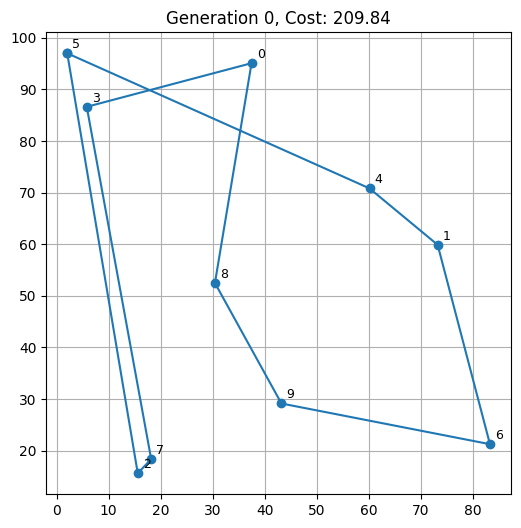

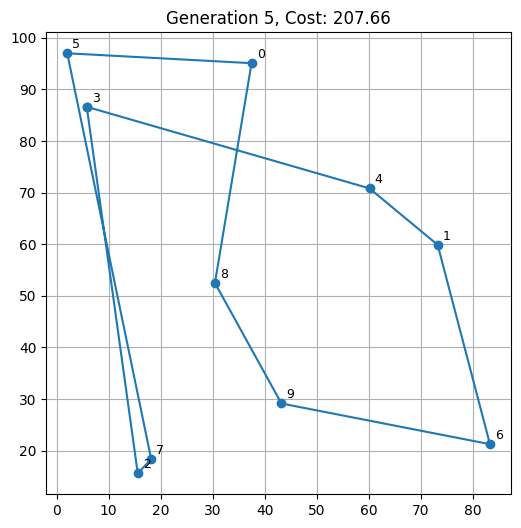

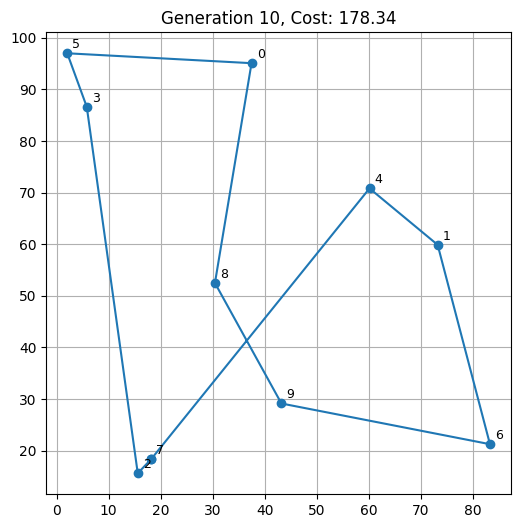

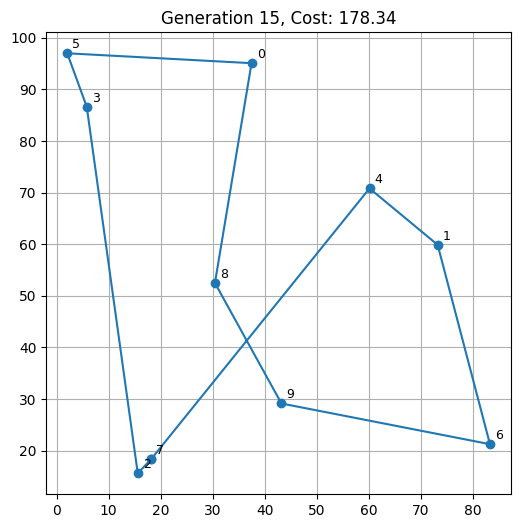

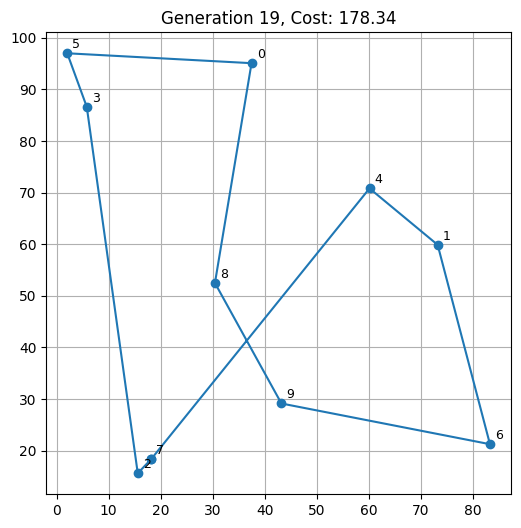

({'truck_route': [7, 2, 3, 5, 0, 8, 9, 6, 1, 4],
  'drone_missions': {0: [], 1: []}},
 np.float64(178.3392452291529))

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy

# Random Seed
np.random.seed(42)

# ------------------------
# Example parameters (10 customers, 2 drones)
# ------------------------
num_customers = 10
num_drones = 2
customers = np.random.rand(num_customers, 2) * 100  # Customer coordinates (x, y)
distance_matrix = np.linalg.norm(customers[:, np.newaxis, :] - customers[np.newaxis, :, :], axis=2)

# Truck and drone parameters
truck_params = {
    'capacity': 10,
    'time_weight': 0.5
}
drone_params = {
    'battery_capacity': 50,  # Battery life
    'time_weight': 0.5,
    'energy_weight': 0.5
}

# Genetic algorithm parameters
num_generations = 20
pop_size = 10
crossover_rate = 0.8
mutation_rate = 0.2
elitism = 1

# Evaluation function: Calculate the total time and energy of the path
def evaluate(individual):
    total_time = 0
    total_energy = 0

    # Truck Routes
    truck_route = individual['truck_route']
    for i in range(len(truck_route) - 1):
        total_time += distance_matrix[truck_route[i], truck_route[i + 1]] * truck_params['time_weight']
    total_time += distance_matrix[truck_route[-1], truck_route[0]] * truck_params['time_weight']

    # Drone missions
    for handover, missions in individual['drone_missions'].items():
        for mission in missions:
            total_time += distance_matrix[handover, mission] * drone_params['time_weight']
            total_energy += distance_matrix[handover, mission] * drone_params['energy_weight']

            # Return to junction point (if necessary)
            total_time += distance_matrix[mission, handover] * drone_params['time_weight']
            total_energy += distance_matrix[mission, handover] * drone_params['energy_weight']

    # Cost function calculation: including time and energy
    return total_time + total_energy

# Initialize the population
def initialize_population():
    population = []
    for _ in range(pop_size):
        chrom = {
            'truck_route': np.random.permutation(num_customers).tolist(),
            'drone_missions': {i: [] for i in range(num_drones)}
        }
        population.append(chrom)
    return population

# Selection Operations (Tournament Selection)
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(range(len(population)), k)
    selected = sorted(selected, key=lambda i: fitnesses[i])
    return population[selected[0]]

# Single point crossover
def crossover(parent1, parent2):
    if random.random() > crossover_rate:
        return deepcopy(parent1)
    cut = random.randint(1, num_customers - 2)
    child = deepcopy(parent1)
    child['truck_route'] = parent1['truck_route'][:cut] + [gene for gene in parent2['truck_route'] if gene not in parent1['truck_route'][:cut]]
    return child

# Mutation operation (swap two positions)
def mutate(individual):
    if random.random() > mutation_rate:
        return individual
    i, j = random.sample(range(num_customers), 2)
    individual['truck_route'][i], individual['truck_route'][j] = individual['truck_route'][j], individual['truck_route'][i]
    return individual

# 主遗传算法
def genetic_algorithm():
    population = initialize_population()
    best_costs = []

    for generation in range(num_generations):
        fitnesses = [evaluate(ind) for ind in population]
        new_population = []

        # Elite Retention
        elite_indices = np.argsort(fitnesses)[:elitism]
        for i in elite_indices:
            new_population.append(population[i])

        # Generate new individuals
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population
        best_idx = np.argmin([evaluate(ind) for ind in population])
        best_cost = evaluate(population[best_idx])
        best_costs.append(best_cost)

        # Visualize the current optimal path
        if generation % 5 == 0 or generation == num_generations - 1:
            best_route = population[best_idx]
            plot_route(best_route, generation, best_cost)

    return population[best_idx], best_costs

# Visualize the path
def plot_route(route, generation, cost):
    plt.figure(figsize=(6, 6))
    route_coords = customers[route['truck_route'] + [route['truck_route'][0]]]
    plt.plot(route_coords[:, 0], route_coords[:, 1], marker='o')
    plt.title(f"Generation {generation}, Cost: {cost:.2f}")
    for idx, (x, y) in enumerate(customers):
        plt.text(x + 1, y + 1, str(idx), fontsize=9)
    plt.grid(True)
    plt.show()

# Run the genetic algorithm
best_solution, cost_trace = genetic_algorithm()
best_solution, cost_trace[-1]
